# Analyze Ball on Incline data
Use this notebook to quickly test whether your ball on incline data makes sense!

In [306]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, argrelmax, find_peaks
from iminuit import Minuit
from iminuit import cost
from iminuit.cost import LeastSquares
from scipy import stats

## Reading the data

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

In [307]:
def read_csv(filename):
    """Read CSV from Waveforms"""
    time = []
    voltage = []
    for i in filename:
        dat = np.genfromtxt(i, delimiter=',', skip_header=13, names=True)
        time.append(dat['Time_s'])
        voltage.append(dat['Channel_1_V'])
    return time, voltage

def find_midpoints(time, voltage, show_plot=True):
    """Find timing of ball crossings"""
    
    # Write a function yourself, which identifies the peaks in the voltage,
    # and returns values for passing times and (possibly) their uncertainties
    # in it (but they are generally very small!).
    t_pass = np.array([])
    v_pass = np.array([])
    # Find the peaks
    #peaks = find_peaks(voltage, height=3.5, distance=100)
    peaks = []
    for i in range(len(voltage)-1):
        if voltage[i] >= 2.5 and voltage[i-1] < 2.5:
            peaks.append(i)
    t_pass = time[peaks]
    v_pass = voltage[peaks]

    if show_plot == True:
        plt.plot(time, voltage)
        plt.scatter(t_pass, v_pass, color='red')
        plt.show()

    t_pass_sigma = [0.0001, 0.00001]
    
    return t_pass, t_pass_sigma, v_pass

In [308]:
# LAV VÆGTET GENNEMSNIT AF NORD OG SYD
theta_1 = np.mean(np.array([13.9, 13.9, 13.9, 13.9, 14]))*(np.pi/180)
theta_2 = np.mean(np.array([13.4, 13.3, 13.3, 13.32, 13.6]))*(np.pi/180)
theta_sig_1 = np.std(np.array([13.9, 13.9, 13.9, 13.9, 14])*(np.pi/180))
theta_sig_2 = np.std(np.array([13.4, 13.3, 13.3, 13.32, 13.6])*(np.pi/180))
theta_val = (theta_1/theta_sig_1**2 + theta_2/theta_sig_2**2)/(1/theta_sig_1**2 + 1/theta_sig_2**2)
theta_sigma_val = np.sqrt(1/(1/theta_sig_1**2 + 1/theta_sig_2**2))

print(theta_val, theta_sigma_val)


0.24192631275390275 0.0006588346979504226
0.23827234948226583


[array([0.24156, 0.47476, 0.64894, 0.78062, 0.90532]), array([0.62772, 0.86092, 1.03518, 1.16698, 1.29174]), array([0.3855 , 0.61828, 0.79244, 0.9242 , 1.0489 ]), array([0.26708, 0.49972, 0.67378, 0.80538, 0.92998]), array([0.48254, 0.71592, 0.89024, 1.02206, 1.14676])]


Text(0, 0.5, 'Voltage (V)')

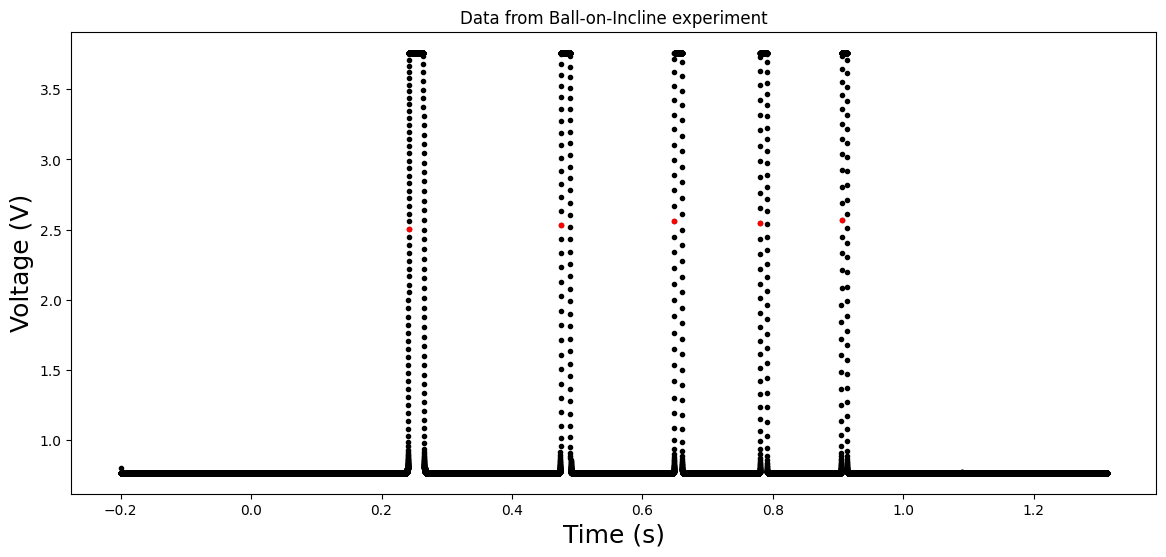

In [309]:
# Read the data and plot it (possibly with passing times in):
filename = ['data_rasmus_1_vest.csv', 'data_franne_1_vest.csv', 'data_mattis_1_vest.csv', 'data_laurits_1_vest.csv', 'data_seb_1_vest.csv']

time, voltage = read_csv(filename)


timepass = []
timepass_sigma = []
vpass = []
for i in range(len(time)):
    t_pass, t_pass_sigma, v_pass = find_midpoints(time[i], voltage[i], show_plot=False)
    timepass.append(t_pass)
    timepass_sigma.append(t_pass_sigma)
    vpass.append(v_pass)

print(timepass)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(time[0], voltage[0], 'k.', label='Measurements')
ax.plot(timepass[0], vpass[0], 'r.', label='Passing times')
ax.set_title("Data from Ball-on-Incline experiment")
ax.set_xlabel("Time (s)", fontsize=18)
ax.set_ylabel("Voltage (V)", fontsize=18)

# What to do next?

From the V(t) data you should be able to determine five times at which the ball passed. Discuss in the group how to do this best, and possibly test it by seeing if the result is "invariant" between different data sets.

Note that getting an uncertainty can be hard, and think about the relevance of such an uncertainty, which should anyway be rather small.

In [310]:
gate_positions = np.array([[22.55, 38.2, 55.9, 72.35, 90.25], 
                           [21.6, 38.1, 55.85, 72.3, 90.3], 
                           [21.55, 38.1, 55.85, 72.3, 90.25],
                           [21.63, 38.1, 55.85, 72.35, 90.25],
                           [21.57, 38.1, 55.85, 72.25, 90.25]])/100

gate_positions_mean = np.mean(gate_positions, axis=0)
gate_positions_std = np.std(gate_positions, axis=0)

def quad_fit(t, a, v0, x0):
    return 1/2 * a * t**2 + v0*t + x0

a_vals = []
a_err_vals = []

for i in range(len(timepass)):
    fit = cost.LeastSquares(timepass[i], gate_positions_mean, gate_positions_std, quad_fit)
    mfit = Minuit(fit, a=1, v0=0, x0=0)
    mfit.migrad()
    a_vals.append(mfit.values['a'])
    a_err_vals.append(mfit.errors['a'])

In [311]:
a_weighted_mean = np.sum(np.array(a_vals)/np.array(a_err_vals)**2)/np.sum(1/np.array(a_err_vals)**2)
a_weighted_sigma = np.sqrt(1/np.sum(1/np.array(a_err_vals)**2))

print(a_weighted_mean, a_weighted_sigma)

chi2 = mfit.fval                    
Ndof = len(timepass) - mfit.nfit     
Prob = stats.chi2.sf(chi2, Ndof) 

print(chi2/Ndof)
print(Prob)
#print(f"$\chi^2$ / $N_\mathrm{{dof}}$ = {chi2:.1f}, {Ndof}", f"Prob($\chi^2$, $N_\mathrm{{dof}}$) = {Prob:.3f}")

1.502741965898594 0.005631761342342905
0.23440050474986437
0.791044935189806


## G with error

In [312]:
from IPython.core.display import Latex

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` a
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

In [313]:

# Import SymPy: 
from sympy import * 
    
# Define variables:
a,theta,Dtheta,Dball,drail  = symbols("a,theta,Dtheta,Dball,drail")
da,dtheta,dDtheta,dDball,ddrail = symbols("sigma_a, sigma_theta, sigma_Dtheta, sigma_Dball, sigma_drail")

# Define relation, and print:
g = a / sin(theta + Dtheta) * (1 + 2/5 * Dball**2 / (Dball**2 - drail**2))
lprint(latex(Eq(symbols('g'),g)))

# Calculate uncertainty and print:
dg = sqrt((g.diff(a) * da)**2 + (g.diff(theta) * dtheta)**2+(g.diff(Dtheta) * dDtheta)**2+(g.diff(Dball) * dDball)**2+(g.diff(drail) * ddrail)**2)
lprint(latex(Eq(symbols('sigma_g'), dg)))

# Turn expression into numerical functions 
fg = lambdify((a,theta,Dtheta,Dball,drail),g)
fdg = lambdify((a,da,theta,dtheta,Dtheta,dDtheta,Dball,dDball,drail,ddrail),dg)

# Define values and their errors
va , vda          = a_weighted_mean, a_weighted_sigma
vtheta, vdtheta   = theta_val, theta_sigma_val
vDtheta, vdDtheta = 0 , 0
vDball, vdDball   = 0.015, 0.0001
vdrail, vddrail   = np.mean(np.array([6.0, 6.0, 5.9, 6.1, 6.0])/1000), np.std(np.array([6.0, 6.0, 5.9, 6.1, 6.0])/1000)

# Numerically evaluate expressions and print 
vg = fg(va,vtheta,vDtheta,vDball,vdrail)
vdg = fdg(va,vda,vtheta,vdtheta,vDtheta,vdDtheta,vDball,vdDball,vdrail,vddrail)
lprint(fr'g = ({vg:.2f} \pm {vdg:.2f})\,\mathrm{{m/s^2}}')

g_err_cont = []
dg_a = (g.diff(a) * da)**2
fdg_a = lambdify((a,da,theta,dtheta,Dtheta,dDtheta,Dball,dDball,drail,ddrail),dg_a)
vdg_a = fdg_a(va,vda,vtheta,vdtheta,vDtheta,vdDtheta,vDball,vdDball,vdrail,vddrail)
g_err_cont.append(vdg_a)

dg_theta = (g.diff(theta) * dtheta)**2
fdg_theta = lambdify((a,da,theta,dtheta,Dtheta,dDtheta,Dball,dDball,drail,ddrail),dg_theta)
vdg_theta = fdg_theta(va,vda,vtheta,vdtheta,vDtheta,vdDtheta,vDball,vdDball,vdrail,vddrail)
g_err_cont.append(vdg_theta)

dg_Dtheta = (g.diff(Dtheta) * dDtheta)**2
fdg_Dtheta = lambdify((a,da,theta,dtheta,Dtheta,dDtheta,Dball,dDball,drail,ddrail),dg_Dtheta)
vdg_Dtheta = fdg_Dtheta(va,vda,vtheta,vdtheta,vDtheta,vdDtheta,vDball,vdDball,vdrail,vddrail)
g_err_cont.append(vdg_Dtheta)

dg_Dball = (g.diff(Dball) * dDball)**2
fdg_Dball = lambdify((a,da,theta,dtheta,Dtheta,dDtheta,Dball,dDball,drail,ddrail),dg_Dball)
vdg_Dball = fdg_Dball(va,vda,vtheta,vdtheta,vDtheta,vdDtheta,vDball,vdDball,vdrail,vddrail)
g_err_cont.append(vdg_Dball)

dg_drail = (g.diff(drail) * ddrail)**2
fdg_drail = lambdify((a,da,theta,dtheta,Dtheta,dDtheta,Dball,dDball,drail,ddrail),dg_drail)
vdg_drail = fdg_drail(va,vda,vtheta,vdtheta,vDtheta,vdDtheta,vDball,vdDball,vdrail,vddrail)
g_err_cont.append(vdg_drail)

g_err_cont

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

[0.0012041941338286663,
 0.0006111989184243272,
 0.0,
 5.754562758116121e-05,
 0.00014386406895290115]